<a href="https://colab.research.google.com/github/SummerGarden610/2025_bioinfo_project/blob/main/cd5l_RBP_project_Your_Own_Analysis_3_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# STEP 1: 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import os

pwm_dir = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir"

# PWM 파일 목록 확인
pwm_files = sorted([f for f in os.listdir(pwm_dir) if f.endswith(".pwm")])
print(f"📁 PWM 파일 개수: {len(pwm_files)}")
print("🔍 상위 10개 파일 이름:")
print(pwm_files[:10])


📁 PWM 파일 개수: 74
🔍 상위 10개 파일 이름:
['1004_8676391.pwm', '1026_10858445.pwm', '1052_17318228.pwm', '1053_17318228.pwm', '114_7499328.pwm', '115_7499328.pwm', '1169_19561594.pwm', '1170_19561594.pwm', '1171_19561594.pwm', '1172_19561594.pwm']


In [29]:
import os
import numpy as np

# 1. NLRP10 3'UTR 서열 정의 (줄바꿈/공백 제거 및 소문자 통일)
nlrp10_3utr_seq = """
gagagagagagagagagagagagaaataaaagataattagataattaagaccaggagtcttagcatgtgcaatgaaagattcactgaaagaaccagcccttaccacagatattggaagtttaattagttagcatccctcccccctagtaggtgctcagtatctcctgtggtgtgaagtcactttgagtagccccattctacgctaacatccaatgactagactttaattctaacattagattctttttaaataaaataaactttaaaataagaaagtgagaatcacatacattctgtaaaatataggcatatatggaacacatgtaaaggaaacatactttggtataatggaaagtcctattgactctatttgtgttcaagtatttgcttaaataaagaatagcttctcattctttctagaaacttctacactttctattgttaaaagtgggtcatgggtggtcacagccctaaacactggtctgggaaattcttctttgctttgacccgactaaattatgtactaatattgatcatattagtactgttagccccagctatgccatcaaccgacttttcttcatgaaaagatgatgcagttccaagattgggcatatcattttctactctgggtctttctataatagaaagaaaaggactttttgctgtaggcataatgagttgattgaactccttgtgtagtggaggacattgaggtataatcaagagccctgtctatttcttagattcctcagaaagttcttgaccctcacatcatagctaaccatgcagaagcctgcagagactgccaacatggcactgaatcctgctcagtggctattgttggccctagtcagctgagtatgggtcccttagctccacagaaaaccttacagacaggactcttgctttttcttattttttcctcatgagtcgatcccataggtagcaattccagttatctgctggatatacccagatgtctgggtgcaaggaactcagccttgaacagtgagtttaggacatggtagccctggtaactagtttccacatggtaaatgtggtggcttgacatttgacaatcatgcccatggtaagttgaacctacagatagtgtgcatatacagaatatgtctaaggagcagtctgtgtgctcacaagcttatttagagagcatttgacaactggtcagctgggtgctgcttattgatacctgctgaactagtctgtgttgtctctgcaaacaagtgatgctctcacaagaccaactcccaagtgccatgaataatttgggaataatgaaacaggtatacagcactatgtttaagtaacaggaactaacacacaacaatgactctagacatgttctaagattccactaaggagacacattcaattctaactggcttgagcaaaagattaaamgacccaatagttttacaaaaagccagaaacaataaagagaaactctacttgatttttagttttgaacactactgactctattgtttttgtttaaaacagggtctcaggcagtcaaggctggtctcaaacttactatgtagtctaggatgacctcgaacttctgtcccttgtacctgcatctcccaggtgtggatatgctgctctttctactaaattaattattgatattcctcctcccctgttgctactggtgctaactaacatatatcagaaaattagctgaagaagtagagttaaaagattctagcgatcgctctaggctttatttcttgaaggagaatattttcaatcttgttttacagcttatttcagagagggatcctggaaatatttacagagtttttttagccttaagttgtatgatgtagagacctttcataaagactttaccacgttgaacacagaaccttgcaaattcctacatagaataaaaggacatagatttacagatgacaatgtccttctattagaaaagttgaccattggaaatgagaactcctatgagcctagggatgatcaagagatgatctagtcccagagagacctacactaacaggcttctataactagttggtcacacagggggactgaacctataacttcatatgagctaggcaagtaagttatgtccctattcacccccacagctaccttttcaagagaattccactgagttgcccaggttatccttgaactcatgctgtagcttatgatcttcctgcctggtatccagagtagcttgggttgcaggctcagatgaccagacatacctctcaactagcctttattgttttgttttgttttttttgcctttaatttgctgctcatagagactcaaaatgctttgacttttgccatttcttcttttaaataaaatttattttaaaaagt
""".replace("\n", "").replace(" ", "").lower()

# 2. PWM 로딩 함수
def load_pwm(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        matrix = np.array([[float(x) for x in line.strip().split()] for line in lines])
    return matrix

# 3. PWM 스코어 계산
def pwm_score(pwm, seq):
    base_index = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    score = 0
    for i, base in enumerate(seq):
        if base not in base_index:
            return -np.inf
        score += pwm[base_index[base], i]
    return score

# 4. 슬라이딩 윈도우로 매칭
def scan_pwm_on_seq(pwm, seq, min_score=-10.0):
    motif_len = pwm.shape[1]
    hits = []
    for i in range(len(seq) - motif_len + 1):
        window = seq[i:i+motif_len]
        score = pwm_score(pwm, window)
        if score >= min_score:
            hits.append((i, window, round(score, 3)))
    return hits

# 5. 전체 PWM 디렉토리 반복
pwm_dir = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir"
min_score_threshold = 4.0  # 필요시 조정

summary = []

for pwm_file in sorted(os.listdir(pwm_dir)):
    if pwm_file.endswith(".pwm"):
        pwm_path = os.path.join(pwm_dir, pwm_file)
        try:
            pwm = load_pwm(pwm_path)
            hits = scan_pwm_on_seq(pwm, nlrp10_3utr_seq, min_score=min_score_threshold)
            if hits:
                summary.append({
                    "pwm_file": pwm_file,
                    "hit_count": len(hits),
                    "top_hit": hits[0]
                })
        except Exception as e:
            print(f"⚠️ 오류 발생 - {pwm_file}: {e}")

# 결과 출력
print(f"\n✅ NLRP10 3'UTR에서 매칭된 PWM 수: {len(summary)}개")
print("📌 상위 5개 결과 예시:")
for item in summary[:5]:
    print(f"{item['pwm_file']} - 총 매칭: {item['hit_count']}개, 첫 매칭: {item['top_hit']}")



✅ NLRP10 3'UTR에서 매칭된 PWM 수: 73개
📌 상위 5개 결과 예시:
1004_8676391.pwm - 총 매칭: 2개, 첫 매칭: (544, 'ctgttagccccagctatg', np.float64(4.179))
1026_10858445.pwm - 총 매칭: 18개, 첫 매칭: (110, 'attggaagttt', np.float64(4.68))
1052_17318228.pwm - 총 매칭: 8개, 첫 매칭: (1155, 'cacaa', np.float64(7.656))
1053_17318228.pwm - 총 매칭: 32개, 첫 매칭: (153, 'ctcag', np.float64(4.488))
114_7499328.pwm - 총 매칭: 30개, 첫 매칭: (29, 'aagata', np.float64(4.223))


In [37]:
import pandas as pd

# 1. 매칭 결과 (summary) 예시 리스트


pwm_files = {
    "NCL": "1026_10858445.pwm",
    "IGF2BP1": "1004_8676391.pwm"
}

# 2. matrix_list.txt 로딩
matrix_list_path = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir/matrix_list.txt"
matrix_df = pd.read_csv(matrix_list_path, sep="\s+", header=None, names=["motif_id", "rbp_name", "domain"])
matrix_df["pwm_file"] = matrix_df["motif_id"].astype(str) + ".pwm"

# 3. summary를 DataFrame으로 변환
summary_df = pd.DataFrame(summary)

# 4. RBP 이름 매핑
merged_df = pd.merge(summary_df, matrix_df, on="pwm_file", how="left")

# 5. 정리된 결과 보기
import pandas as pd
from IPython.display import display

# 정렬하여 보기 좋게 출력
merged_df_sorted = merged_df.sort_values(by="hit_count", ascending=False)[
    ["pwm_file", "rbp_name", "domain", "hit_count", "top_hit"]
]
display(merged_df_sorted)


,pwm_file,rbp_name,domain,hit_count,top_hit
3,1053_17318228.pwm,RBMY1A1,RRMx1,32,"(153, ctcag, 4.488)"
4,114_7499328.pwm,ybx2-a,CSDx1,30,"(29, aagata, 4.223)"
1,1026_10858445.pwm,NCL,RRMx4,18,"(110, attggaagttt, 4.68)"
2,1052_17318228.pwm,RBMY1A1,RRMx1,8,"(1155, cacaa, 7.656)"
0,1004_8676391.pwm,NCL,RRMx4,2,"(544, ctgttagccccagctatg, 4.179)"


NCL: 18 hits
IGF2BP1: 2 hits


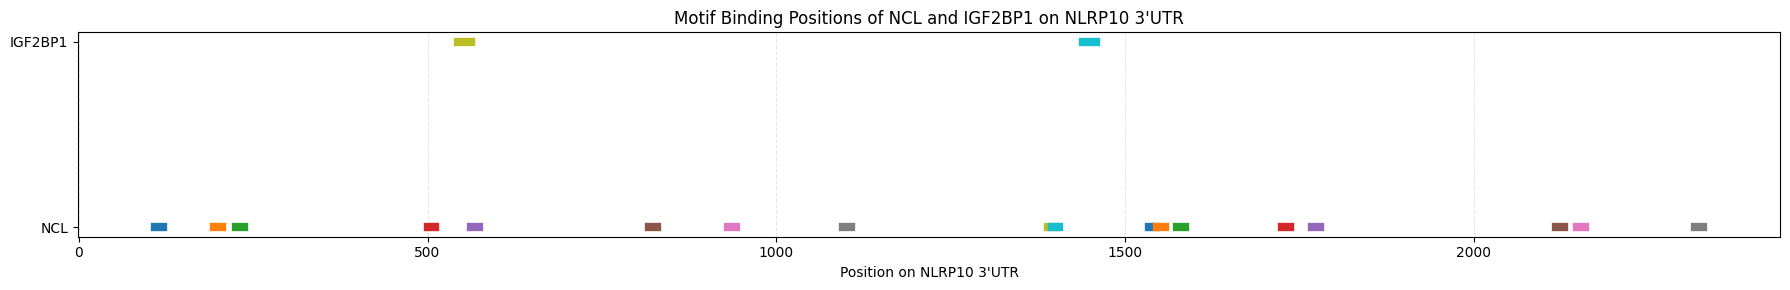

In [39]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. NLRP10 3'UTR 서열 정의
nlrp10_3utr_seq = """gagagagagagagagagagagagaaataaaagataattagataattaagaccaggagtcttagcatgtgcaatgaaagattcactgaaagaaccagcccttaccacagatattggaagtttaattagttagcatccctcccccctagtaggtgctcagtatctcctgtggtgtgaagtcactttgagtagccccattctacgctaacatccaatgactagactttaattctaacattagattctttttaaataaaataaactttaaaataagaaagtgagaatcacatacattctgtaaaatataggcatatatggaacacatgtaaaggaaacatactttggtataatggaaagtcctattgactctatttgtgttcaagtatttgcttaaataaagaatagcttctcattctttctagaaacttctacactttctattgttaaaagtgggtcatgggtggtcacagccctaaacactggtctgggaaattcttctttgctttgacccgactaaattatgtactaatattgatcatattagtactgttagccccagctatgccatcaaccgacttttcttcatgaaaagatgatgcagttccaagattgggcatatcattttctactctgggtctttctataatagaaagaaaaggactttttgctgtaggcataatgagttgattgaactccttgtgtagtggaggacattgaggtataatcaagagccctgtctatttcttagattcctcagaaagttcttgaccctcacatcatagctaaccatgcagaagcctgcagagactgccaacatggcactgaatcctgctcagtggctattgttggccctagtcagctgagtatgggtcccttagctccacagaaaaccttacagacaggactcttgctttttcttattttttcctcatgagtcgatcccataggtagcaattccagttatctgctggatatacccagatgtctgggtgcaaggaactcagccttgaacagtgagtttaggacatggtagccctggtaactagtttccacatggtaaatgtggtggcttgacatttgacaatcatgcccatggtaagttgaacctacagatagtgtgcatatacagaatatgtctaaggagcagtctgtgtgctcacaagcttatttagagagcatttgacaactggtcagctgggtgctgcttattgatacctgctgaactagtctgtgttgtctctgcaaacaagtgatgctctcacaagaccaactcccaagtgccatgaataatttgggaataatgaaacaggtatacagcactatgtttaagtaacaggaactaacacacaacaatgactctagacatgttctaagattccactaaggagacacattcaattctaactggcttgagcaaaagattaaamgacccaatagttttacaaaaagccagaaacaataaagagaaactctacttgatttttagttttgaacactactgactctattgtttttgtttaaaacagggtctcaggcagtcaaggctggtctcaaacttactatgtagtctaggatgacctcgaacttctgtcccttgtacctgcatctcccaggtgtggatatgctgctctttctactaaattaattattgatattcctcctcccctgttgctactggtgctaactaacatatatcagaaaattagctgaagaagtagagttaaaagattctagcgatcgctctaggctttatttcttgaaggagaatattttcaatcttgttttacagcttatttcagagagggatcctggaaatatttacagagtttttttagccttaagttgtatgatgtagagacctttcataaagactttaccacgttgaacacagaaccttgcaaattcctacatagaataaaaggacatagatttacagatgacaatgtccttctattagaaaagttgaccattggaaatgagaactcctatgagcctagggatgatcaagagatgatctagtcccagagagacctacactaacaggcttctataactagttggtcacacagggggactgaacctataacttcatatgagctaggcaagtaagttatgtccctattcacccccacagctaccttttcaagagaattccactgagttgcccaggttatccttgaactcatgctgtagcttatgatcttcctgcctggtatccagagtagcttgggttgcaggctcagatgaccagacatacctctcaactagcctttattgttttgttttgttttttttgcctttaatttgctgctcatagagactcaaaatgctttgacttttgccatttcttcttttaaataaaatttattttaaaaagt""".replace("\n", "").replace(" ", "").lower()

# 2. PWM 로딩 함수
def load_pwm(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        matrix = np.array([[float(x) for x in line.strip().split()] for line in lines])
    return matrix

# 3. PWM 스코어 계산 함수
def pwm_score(pwm, seq):
    base_index = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    score = 0
    for i, base in enumerate(seq):
        if base not in base_index:
            return -np.inf
        score += pwm[base_index[base], i]
    return score

# 4. PWM 매칭 함수
def scan_pwm_on_seq(pwm, seq, min_score=4.0):
    motif_len = pwm.shape[1]
    hits = []
    for i in range(len(seq) - motif_len + 1):
        window = seq[i:i+motif_len]
        score = pwm_score(pwm, window)
        if score >= min_score:
            hits.append((i, i + motif_len))  # (start, end)
    return hits

# 5. 매칭할 PWM 파일 정의
pwm_dir = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir"
pwm_files = {
    "NCL": "1026_10858445.pwm",
    "IGF2BP1": "1004_8676391.pwm"
}

# 6. 각 motif에 대해 매칭 수행
hit_positions = {}

for label, pwm_filename in pwm_files.items():
    pwm_path = os.path.join(pwm_dir, pwm_filename)
    try:
        pwm = load_pwm(pwm_path)
        hits = scan_pwm_on_seq(pwm, nlrp10_3utr_seq, min_score=4.0)
        hit_positions[label] = hits
        print(f"{label}: {len(hits)} hits")
    except Exception as e:
        print(f"⚠️ 오류 발생 - {label}: {e}")

# 7. 시각화
# label → index 매핑
labels = list(hit_positions.keys())
label_to_idx = {label: i for i, label in enumerate(labels)}

plt.figure(figsize=(18, 3))

for label, positions in hit_positions.items():
    y = label_to_idx[label]
    for (start, end) in positions:
        plt.plot([start, end], [y, y], lw=6)

plt.xlabel("Position on NLRP10 3'UTR")
plt.yticks(list(label_to_idx.values()), list(label_to_idx.keys()))
plt.title("Motif Binding Positions of NCL and IGF2BP1 on NLRP10 3'UTR")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


NCL: 18 hits
IGF2BP1: 2 hits


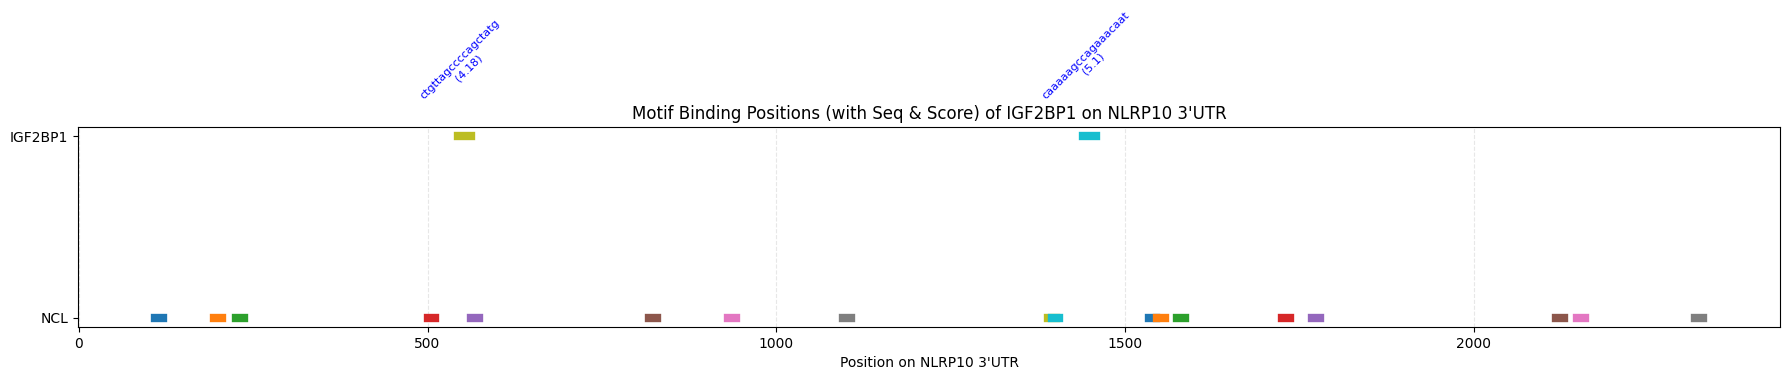

In [43]:
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. NLRP10 3'UTR 서열 정의
nlrp10_3utr_seq = """gagagagagagagagagagagagaaataaaagataattagataattaagaccaggagtcttagcatgtgcaatgaaagattcactgaaagaaccagcccttaccacagatattggaagtttaattagttagcatccctcccccctagtaggtgctcagtatctcctgtggtgtgaagtcactttgagtagccccattctacgctaacatccaatgactagactttaattctaacattagattctttttaaataaaataaactttaaaataagaaagtgagaatcacatacattctgtaaaatataggcatatatggaacacatgtaaaggaaacatactttggtataatggaaagtcctattgactctatttgtgttcaagtatttgcttaaataaagaatagcttctcattctttctagaaacttctacactttctattgttaaaagtgggtcatgggtggtcacagccctaaacactggtctgggaaattcttctttgctttgacccgactaaattatgtactaatattgatcatattagtactgttagccccagctatgccatcaaccgacttttcttcatgaaaagatgatgcagttccaagattgggcatatcattttctactctgggtctttctataatagaaagaaaaggactttttgctgtaggcataatgagttgattgaactccttgtgtagtggaggacattgaggtataatcaagagccctgtctatttcttagattcctcagaaagttcttgaccctcacatcatagctaaccatgcagaagcctgcagagactgccaacatggcactgaatcctgctcagtggctattgttggccctagtcagctgagtatgggtcccttagctccacagaaaaccttacagacaggactcttgctttttcttattttttcctcatgagtcgatcccataggtagcaattccagttatctgctggatatacccagatgtctgggtgcaaggaactcagccttgaacagtgagtttaggacatggtagccctggtaactagtttccacatggtaaatgtggtggcttgacatttgacaatcatgcccatggtaagttgaacctacagatagtgtgcatatacagaatatgtctaaggagcagtctgtgtgctcacaagcttatttagagagcatttgacaactggtcagctgggtgctgcttattgatacctgctgaactagtctgtgttgtctctgcaaacaagtgatgctctcacaagaccaactcccaagtgccatgaataatttgggaataatgaaacaggtatacagcactatgtttaagtaacaggaactaacacacaacaatgactctagacatgttctaagattccactaaggagacacattcaattctaactggcttgagcaaaagattaaamgacccaatagttttacaaaaagccagaaacaataaagagaaactctacttgatttttagttttgaacactactgactctattgtttttgtttaaaacagggtctcaggcagtcaaggctggtctcaaacttactatgtagtctaggatgacctcgaacttctgtcccttgtacctgcatctcccaggtgtggatatgctgctctttctactaaattaattattgatattcctcctcccctgttgctactggtgctaactaacatatatcagaaaattagctgaagaagtagagttaaaagattctagcgatcgctctaggctttatttcttgaaggagaatattttcaatcttgttttacagcttatttcagagagggatcctggaaatatttacagagtttttttagccttaagttgtatgatgtagagacctttcataaagactttaccacgttgaacacagaaccttgcaaattcctacatagaataaaaggacatagatttacagatgacaatgtccttctattagaaaagttgaccattggaaatgagaactcctatgagcctagggatgatcaagagatgatctagtcccagagagacctacactaacaggcttctataactagttggtcacacagggggactgaacctataacttcatatgagctaggcaagtaagttatgtccctattcacccccacagctaccttttcaagagaattccactgagttgcccaggttatccttgaactcatgctgtagcttatgatcttcctgcctggtatccagagtagcttgggttgcaggctcagatgaccagacatacctctcaactagcctttattgttttgttttgttttttttgcctttaatttgctgctcatagagactcaaaatgctttgacttttgccatttcttcttttaaataaaatttattttaaaaagt""".replace("\n", "").replace(" ", "").lower()

# PWM 관련 함수
def load_pwm(filepath):
    with open(filepath, 'r') as f:
        lines = f.readlines()
        matrix = np.array([[float(x) for x in line.strip().split()] for line in lines])
    return matrix

def pwm_score(pwm, seq):
    base_index = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    score = 0
    for i, base in enumerate(seq):
        if base not in base_index:
            return -np.inf
        score += pwm[base_index[base], i]
    return score

# PWM 매칭 함수 (seq, score 포함)
def scan_pwm_on_seq_with_details(pwm, seq, min_score=4.0):
    motif_len = pwm.shape[1]
    hits = []
    for i in range(len(seq) - motif_len + 1):
        window = seq[i:i+motif_len]
        score = pwm_score(pwm, window)
        if score >= min_score:
            hits.append((i, i + motif_len, window, round(score, 2)))
    return hits

# 대상 PWM 파일
pwm_dir = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir"
pwm_files = {
    "NCL": "1026_10858445.pwm",
    "IGF2BP1": "1004_8676391.pwm"
}

# motif 매칭
hit_positions = {}

for label, pwm_filename in pwm_files.items():
    pwm_path = os.path.join(pwm_dir, pwm_filename)
    pwm = load_pwm(pwm_path)
    hits = scan_pwm_on_seq_with_details(pwm, nlrp10_3utr_seq, min_score=4.0)
    hit_positions[label] = hits
    print(f"{label}: {len(hits)} hits")

# 시각화 (score & seq 표시 포함)
label_to_idx = {label: i for i, label in enumerate(hit_positions)}

plt.figure(figsize=(18, 4))

for label, positions in hit_positions.items():
    y = label_to_idx[label]
    for (start, end, matched_seq, score) in positions:
        plt.plot([start, end], [y, y], lw=6)
        if label == "IGF2BP1":
            mid = (start + end) / 2
            plt.text(mid, y + 0.15, f"{matched_seq}\n({score})",
                     ha='center', va='bottom', fontsize=8, rotation=45, color='blue')

plt.xlabel("Position on NLRP10 3'UTR")
plt.yticks(list(label_to_idx.values()), list(label_to_idx.keys()))
plt.title("Motif Binding Positions (with Seq & Score) of IGF2BP1 on NLRP10 3'UTR")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()


IGF2BP1: 2 hits


<ipython-input-55-2259387246>:52: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


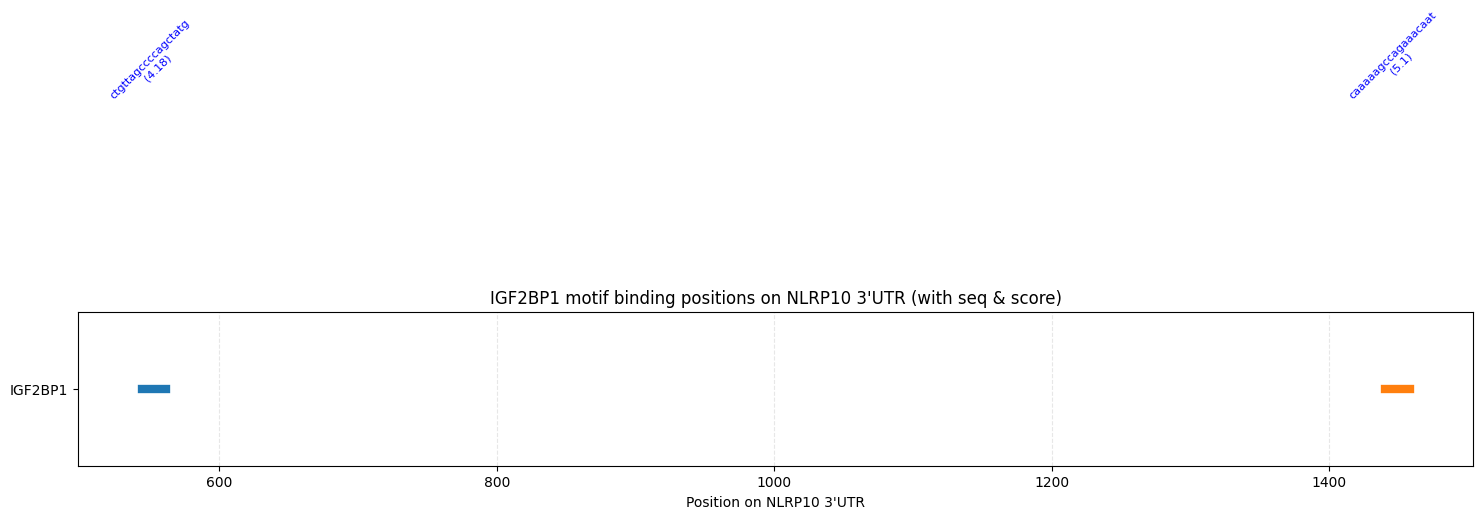

[{'start': 544, 'length': 18, 'seq': 'ctgttagccccagctatg', 'score': np.float64(4.18)}, {'start': 1440, 'length': 18, 'seq': 'caaaaagccagaaacaat', 'score': np.float64(5.1)}]


In [55]:
#mouse nlrp10 3'utr
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. IGF2BP1의 PWM 파일과 레이블 설정
label = "IGF2BP1"
pwm_file = "1004_8676391.pwm"
pwm_path = os.path.join("/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir", pwm_file)

# 2. NLRP10 3'UTR 서열
nlrp10_3utr_seq = """gagagagagagagagagagagagaaataaaagataattagataattaagaccaggagtcttagcatgtgcaatgaaagattcactgaaagaaccagcccttaccacagatattggaagtttaattagttagcatccctcccccctagtaggtgctcagtatctcctgtggtgtgaagtcactttgagtagccccattctacgctaacatccaatgactagactttaattctaacattagattctttttaaataaaataaactttaaaataagaaagtgagaatcacatacattctgtaaaatataggcatatatggaacacatgtaaaggaaacatactttggtataatggaaagtcctattgactctatttgtgttcaagtatttgcttaaataaagaatagcttctcattctttctagaaacttctacactttctattgttaaaagtgggtcatgggtggtcacagccctaaacactggtctgggaaattcttctttgctttgacccgactaaattatgtactaatattgatcatattagtactgttagccccagctatgccatcaaccgacttttcttcatgaaaagatgatgcagttccaagattgggcatatcattttctactctgggtctttctataatagaaagaaaaggactttttgctgtaggcataatgagttgattgaactccttgtgtagtggaggacattgaggtataatcaagagccctgtctatttcttagattcctcagaaagttcttgaccctcacatcatagctaaccatgcagaagcctgcagagactgccaacatggcactgaatcctgctcagtggctattgttggccctagtcagctgagtatgggtcccttagctccacagaaaaccttacagacaggactcttgctttttcttattttttcctcatgagtcgatcccataggtagcaattccagttatctgctggatatacccagatgtctgggtgcaaggaactcagccttgaacagtgagtttaggacatggtagccctggtaactagtttccacatggtaaatgtggtggcttgacatttgacaatcatgcccatggtaagttgaacctacagatagtgtgcatatacagaatatgtctaaggagcagtctgtgtgctcacaagcttatttagagagcatttgacaactggtcagctgggtgctgcttattgatacctgctgaactagtctgtgttgtctctgcaaacaagtgatgctctcacaagaccaactcccaagtgccatgaataatttgggaataatgaaacaggtatacagcactatgtttaagtaacaggaactaacacacaacaatgactctagacatgttctaagattccactaaggagacacattcaattctaactggcttgagcaaaagattaaamgacccaatagttttacaaaaagccagaaacaataaagagaaactctacttgatttttagttttgaacactactgactctattgtttttgtttaaaacagggtctcaggcagtcaaggctggtctcaaacttactatgtagtctaggatgacctcgaacttctgtcccttgtacctgcatctcccaggtgtggatatgctgctctttctactaaattaattattgatattcctcctcccctgttgctactggtgctaactaacatatatcagaaaattagctgaagaagtagagttaaaagattctagcgatcgctctaggctttatttcttgaaggagaatattttcaatcttgttttacagcttatttcagagagggatcctggaaatatttacagagtttttttagccttaagttgtatgatgtagagacctttcataaagactttaccacgttgaacacagaaccttgcaaattcctacatagaataaaaggacatagatttacagatgacaatgtccttctattagaaaagttgaccattggaaatgagaactcctatgagcctagggatgatcaagagatgatctagtcccagagagacctacactaacaggcttctataactagttggtcacacagggggactgaacctataacttcatatgagctaggcaagtaagttatgtccctattcacccccacagctaccttttcaagagaattccactgagttgcccaggttatccttgaactcatgctgtagcttatgatcttcctgcctggtatccagagtagcttgggttgcaggctcagatgaccagacatacctctcaactagcctttattgttttgttttgttttttttgcctttaatttgctgctcatagagactcaaaatgctttgacttttgccatttcttcttttaaataaaatttattttaaaaagt""".replace("\n", "").replace(" ", "").lower()

# 3. PWM 로딩 및 매칭 함수
def load_pwm(filepath):
    with open(filepath, 'r') as f:
        matrix = np.array([[float(x) for x in line.strip().split()] for line in f])
    return matrix

def pwm_score(pwm, seq):
    base_index = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    return sum(pwm[base_index[base], i] if base in base_index else -np.inf for i, base in enumerate(seq))

def scan_pwm_on_seq_with_details(pwm, seq, min_score=4.0):
    motif_len = pwm.shape[1]
    hits = []
    for i in range(len(seq) - motif_len + 1):
        window = seq[i:i+motif_len]
        score = pwm_score(pwm, window)
        if score >= min_score:
            hits.append((i, i + motif_len, window, round(score, 2)))
    return hits

# 4. PWM 로드 및 매칭 실행
pwm = load_pwm(pwm_path)
hits = scan_pwm_on_seq_with_details(pwm, nlrp10_3utr_seq, min_score=4.0)
print(f"{label}: {len(hits)} hits")

# 5. 시각화 (IGF2BP1만 표시)
plt.figure(figsize=(18, 2))
y = 0  # 단일 라벨이므로 고정

for (start, end, matched_seq, score) in hits:
    plt.plot([start, end], [y, y], lw=6)
    mid = (start + end) / 2
    plt.text(mid, y + 0.2, f"{matched_seq}\n({score})",
             ha='center', va='bottom', fontsize=8, rotation=45, color='blue')

plt.yticks([y], [label])
plt.xlabel("Position on NLRP10 3'UTR")
plt.title(f"IGF2BP1 motif binding positions on NLRP10 3'UTR (with seq & score)")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ✅ motif 매칭된 결과를 리스트로 추출
motif_hits = [
    {"start": start, "length": len(seq), "seq": seq, "score": score}
    for (start, end, seq, score) in hits
]
print(motif_hits)


IGF2BP1: 1 hits


<ipython-input-57-2615265661>:53: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


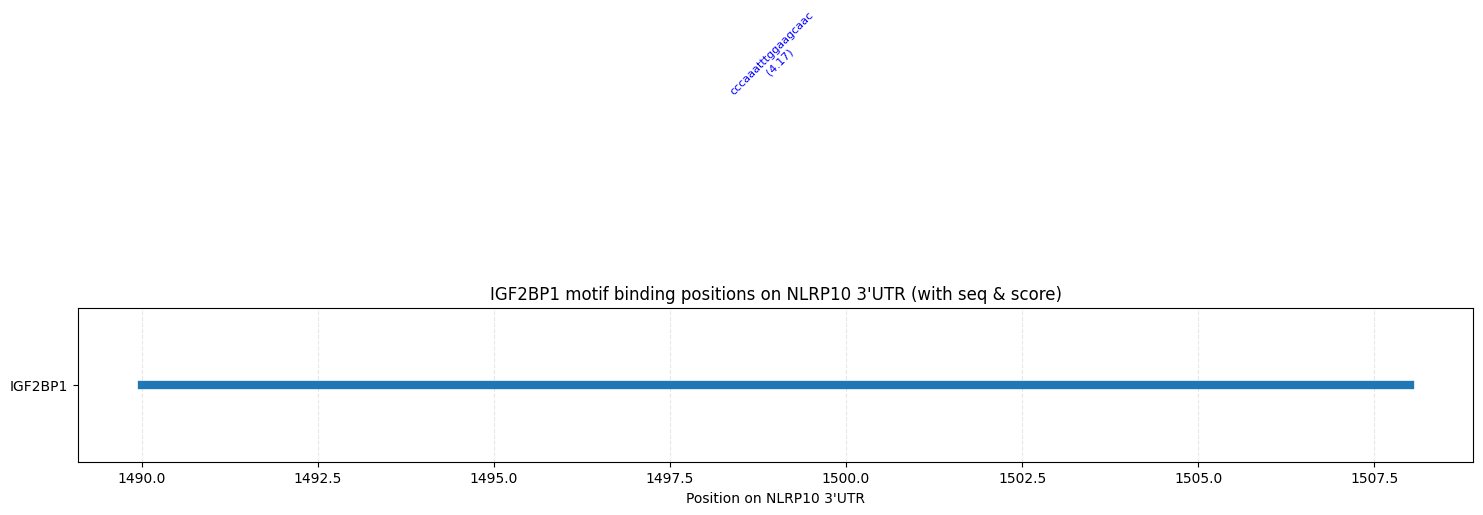

[{'start': 1490, 'length': 18, 'seq': 'cccaaatttggaagcaac', 'score': np.float64(4.17)}]


In [57]:
#human nlrp10 3'utr
import os
import numpy as np
import matplotlib.pyplot as plt

# 1. IGF2BP1의 PWM 파일과 레이블 설정
label = "IGF2BP1"
pwm_file = "1004_8676391.pwm"
pwm_path = os.path.join("/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir", pwm_file)

# 2. NLRP10 3'UTR 서열
nlrp10_3utr_seq = """acctaattaaatatgtacaagatctctatgaggaaaatgacaacactctgaggaaagaaatcaaagaagctgtaaatgaatgggaagattttccatgttcatgaatagaaagactcaatattgttaagatgttagttttccccagtttgatctgtagattcaatgcaatcccaatcaagatcccagcaaataactttgtggacattgataagatgattctaatgtttatgtgcaaaggcaaaagactcagaatagccaataaaatattgaagaagaacaaagttggaggagtgctgctatccaacttcttcctactataaagctacagtaatcaagacagtatggtattgttaaaataatagagaaatcagtggagtagaatagagaaccagaaacaaacctacacaaaatggtcaattgatcttagacaaaggagcaaaagcaatttaatggagaaagtttactcttttcaacaaatggtgctgaaataactggacatccacatgtaaaaaaatgaatctagatgtaaaatacaaaagtactaatataaactgctagaagataatataggagaaaatctaggtgaccttgggtttggcgatgactttttagatataacagcaaaagcatgaatcattaaaaaaagaattagttggcttcatgaaaattaaaaacttatgctctgtgaaagacactgttaagagaatgaaaagataagccaaagactgggagaaaatatttgcaaacacatatctgataaaagacttgggtaaaaaaaatacaaatagctcttaaaactcaataataagtaaagagtctacttaaaaagtgagtaggaggcccaggctggtggatcacgaggtcaagagaccgagaccatcctggccaatgtggtgaaaccccgtctttactaaaaatacgaaagttagccgggcgtggtggtgcacacctgtagtcccagctactcaggaggctgaggcaggagaattgcttgaatctgggaggcggaggttgcagtgagctgagatcgcaccactgcactccagcctggcaacagagtgagactctgcctcaaaaaaaaaaaggtgagtaaaaagattggaacagacagcttattaaagaagatacacagatggcaaataaatatttgaaaagacgctcaacttcatatgtcattagggaattgcaaactaaaaccacaataagataccatgacacccctgttagaatggctaacatcccaaatcctggcaacactaaatgcttgttaggatgtggagtagtgggagccttattcattgctggtcagaatgcaaaatggtacagccactttgaaagacagtttggcagtttcttacaaagctaaacatagttttactatatgtaagatctagcaattatgctcctagatattaacccaagtgagttggaaacttatgtccacataaaaacctgcacatgaatatttatagcagctttattcgtaattgcccaaatttggaagcaaccaagatgtccttcaataggtgatggataagcaaactgtgatacatccacataatgtaatagtattcagtgataaataaatgagcaattaagacatgaaaagatatggagaagccttaaatgcaactactaagtgaaagaagtcagtctgaaaggctacatactgtgtaattccaaatatatgctcttatgaaaaatgaaaaactatggagacaattaaaaatcagtggttgtcaggggttcaaggagagtcagggagagataaccaggtggaggcacaggcactttaggatagtaaaactattctgtgtgatattataatgatggagtcatgacataaatttttcaaaacgcatagagctgtacaatacaaagagtgaatcctaatgtaaactgtgccttgtagttaataatagtgtatcaaaattggttcatcaatgatcacaaatgtgtcacactaatgcaagatgttaataagagaaactttgtgagggggtggtggtggtggagagggtatataggaactttctgtatttaaaaaaagttttattgaagtataattagtttaatacaataaactgtgcatatttaata""".replace("\n", "").replace(" ", "").lower()

# 3. PWM 로딩 및 매칭 함수
def load_pwm(filepath):
    with open(filepath, 'r') as f:
        matrix = np.array([[float(x) for x in line.strip().split()] for line in f])
    return matrix

def pwm_score(pwm, seq):
    base_index = {'a': 0, 'c': 1, 'g': 2, 't': 3}
    return sum(pwm[base_index[base], i] if base in base_index else -np.inf for i, base in enumerate(seq))

def scan_pwm_on_seq_with_details(pwm, seq, min_score=4.0):
    motif_len = pwm.shape[1]
    hits = []
    for i in range(len(seq) - motif_len + 1):
        window = seq[i:i+motif_len]
        score = pwm_score(pwm, window)
        if score >= min_score:
            hits.append((i, i + motif_len, window, round(score, 2)))
    return hits

# 4. PWM 로드 및 매칭 실행
pwm = load_pwm(pwm_path)
hits = scan_pwm_on_seq_with_details(pwm, nlrp10_3utr_seq, min_score=4.0)
print(f"{label}: {len(hits)} hits")

# 5. 시각화 (IGF2BP1만 표시)
plt.figure(figsize=(18, 2))
y = 0  # 단일 라벨이므로 고정

for (start, end, matched_seq, score) in hits:
    plt.plot([start, end], [y, y], lw=6)
    mid = (start + end) / 2
    plt.text(mid, y + 0.2, f"{matched_seq}\n({score})",
             ha='center', va='bottom', fontsize=8, rotation=45, color='blue')

plt.yticks([y], [label])
plt.xlabel("Position on NLRP10 3'UTR")
plt.title(f"IGF2BP1 motif binding positions on NLRP10 3'UTR (with seq & score)")
plt.grid(True, axis='x', linestyle='--', alpha=0.3)
plt.tight_layout()
plt.show()

# ✅ motif 매칭된 결과를 리스트로 추출
motif_hits = [
    {"start": start, "length": len(seq), "seq": seq, "score": score}
    for (start, end, seq, score) in hits
]
print(motif_hits)


In [45]:
# STEP 1: 필요한 라이브러리 설치 및 import
import os
import tarfile

# STEP 2: 작업 디렉토리 생성
os.makedirs("/content/GSE202973", exist_ok=True)
os.chdir("/content/GSE202973")

# STEP 3: GEO supplementary file 다운로드
!wget -O GSE202973_RAW.tar "https://ftp.ncbi.nlm.nih.gov/geo/series/GSE202nnn/GSE202973/suppl/GSE202973_RAW.tar"

# STEP 4: 압축 해제
with tarfile.open("GSE202973_RAW.tar", "r") as tar:
    tar.extractall()
    print("압축 해제 완료")

# STEP 5: 압축된 폴더 내 파일 확인
!ls -lh


--2025-06-12 13:42:20--  https://ftp.ncbi.nlm.nih.gov/geo/series/GSE202nnn/GSE202973/suppl/GSE202973_RAW.tar
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.13, 130.14.250.31, 130.14.250.7, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130672640 (125M) [application/x-tar]
Saving to: ‘GSE202973_RAW.tar’

GSE202973_RAW.tar   100%[===================>] 124.62M  33.3MB/s    in 3.9s    

2025-06-12 13:42:24 (32.0 MB/s) - ‘GSE202973_RAW.tar’ saved [130672640/130672640]

압축 해제 완료
total 250M
-rw-r--r-- 1 root root 125M May 31  2024 GSE202973_RAW.tar
-rw-r--r-- 1 root root  21M May 12  2022 GSM6142364_IP_1.pos.bw
-rw-r--r-- 1 root root  13M May  8  2022 GSM6142365_Input_1.pos.bw
-rw-r--r-- 1 root root  16M May  8  2022 GSM6142366_IP_2.pos.bw
-rw-r--r-- 1 root root  15M May  8  2022 GSM6142367_Input_2.pos.bw
-rw-r--r-- 1 root root  28M May  8  2022 GSM6142368_H929.uniq.bam.

In [46]:
# STEP 1: bigWigToBedGraph 설치 (UCSC 제공)
!apt-get install -y ucsc-bedgraphtobigwig
!wget https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigWigToBedGraph -O /usr/local/bin/bigWigToBedGraph
!chmod +x /usr/local/bin/bigWigToBedGraph


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package ucsc-bedgraphtobigwig
--2025-06-12 13:43:32--  https://hgdownload.soe.ucsc.edu/admin/exe/linux.x86_64/bigWigToBedGraph
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7956136 (7.6M)
Saving to: ‘/usr/local/bin/bigWigToBedGraph’

/usr/local/bin/bigW 100%[===================>]   7.59M  11.0MB/s    in 0.7s    

2025-06-12 13:43:33 (11.0 MB/s) - ‘/usr/local/bin/bigWigToBedGraph’ saved [7956136/7956136]



In [47]:
# IP replicate 1 변환
!bigWigToBedGraph GSM6142364_IP_1.pos.bw GSM6142364_IP_1.bedgraph

# 파일 확인
!head GSM6142364_IP_1.bedgraph


chr1	17315	17355	1
chr1	17355	17435	2
chr1	17435	17465	3
chr1	17465	17470	4
chr1	17470	17505	3
chr1	17505	17590	2
chr1	17590	17615	1
chr1	137760	137785	1
chr1	137785	137795	2
chr1	137795	137855	4


In [48]:
import pandas as pd

# bedgraph 불러오기
bedgraph_df = pd.read_csv("GSM6142364_IP_1.bedgraph", sep="\t", header=None,
                          names=["chrom", "start", "end", "value"])

# NLRP10 좌표 정의
nlrp10_chr = "chr11"
nlrp10_start = 87008242
nlrp10_end = 87020251

# NLRP10 영역과 겹치는 row 필터링
overlap_df = bedgraph_df[
    (bedgraph_df["chrom"] == nlrp10_chr) &
    (bedgraph_df["end"] >= nlrp10_start) &
    (bedgraph_df["start"] <= nlrp10_end)
]

# 결과 출력
import IPython.display as dsp
dsp.display(overlap_df)
print(f"✅ 겹치는 영역 수: {len(overlap_df)}개")


,chrom,start,end,value
1238555,chr11,87009430,87009480,1.0
1238556,chr11,87009480,87009580,2.0
1238557,chr11,87009580,87009630,1.0


✅ 겹치는 영역 수: 3개


In [49]:
# STEP 1: 변환 (bigWigToBedGraph 사용)
!bigWigToBedGraph GSM6142365_Input_1.pos.bw GSM6142365_Input_1.bedgraph

# STEP 2: 변환된 파일 미리보기
!head GSM6142365_Input_1.bedgraph


chr1	17400	17410	1
chr1	17410	17420	3
chr1	17420	17435	7
chr1	17435	17440	8
chr1	17440	17470	10
chr1	17470	17475	12
chr1	17475	17510	16
chr1	17510	17520	12
chr1	17520	17525	8
chr1	17525	17550	6


In [50]:
# STEP 3: bedgraph 파일 로드
input_df = pd.read_csv("GSM6142365_Input_1.bedgraph", sep="\t", header=None,
                       names=["chrom", "start", "end", "value"])

# STEP 4: NLRP10 위치 정의 (동일)
nlrp10_chr = "chr11"
nlrp10_start = 87008242
nlrp10_end = 87020251

# STEP 5: NLRP10 영역과 겹치는 Input 시그널 추출
input_overlap_df = input_df[
    (input_df["chrom"] == nlrp10_chr) &
    (input_df["end"] >= nlrp10_start) &
    (input_df["start"] <= nlrp10_end)
]

# STEP 6: 결과 출력
import IPython.display as dsp
dsp.display(input_overlap_df)
print(f"📊 Input 겹치는 영역 수: {len(input_overlap_df)}개")


,chrom,start,end,value


📊 Input 겹치는 영역 수: 0개


In [51]:
# 평균 시그널 비교
ip_mean = overlap_df['value'].mean()
input_mean = input_overlap_df['value'].mean()

print(f"📈 IP 평균 시그널: {ip_mean:.2f}")
print(f"📉 Input 평균 시그널: {input_mean:.2f}")


📈 IP 평균 시그널: 1.33
📉 Input 평균 시그널: nan


In [52]:
# replicate 2 (IP/Input) 도 비교
# Replicate 2: IP & Input 변환
!bigWigToBedGraph GSM6142366_IP_2.pos.bw GSM6142366_IP_2.bedgraph
!bigWigToBedGraph GSM6142367_Input_2.pos.bw GSM6142367_Input_2.bedgraph

# IP replicate 2
ip2_df = pd.read_csv("GSM6142366_IP_2.bedgraph", sep="\t", header=None,
                     names=["chrom", "start", "end", "value"])
ip2_overlap_df = ip2_df[
    (ip2_df["chrom"] == "chr11") &
    (ip2_df["end"] >= 87008242) &
    (ip2_df["start"] <= 87020251)
]

# Input replicate 2
input2_df = pd.read_csv("GSM6142367_Input_2.bedgraph", sep="\t", header=None,
                        names=["chrom", "start", "end", "value"])
input2_overlap_df = input2_df[
    (input2_df["chrom"] == "chr11") &
    (input2_df["end"] >= 87008242) &
    (input2_df["start"] <= 87020251)
]

# 평균 비교
ip2_mean = ip2_overlap_df['value'].mean()
input2_mean = input2_overlap_df['value'].mean()

print(f"📈 IP replicate 2 평균 시그널: {ip2_mean}")
print(f"📉 Input replicate 2 평균 시그널: {input2_mean}")
print(f"✅ IP2 겹친 영역 수: {len(ip2_overlap_df)}, Input2: {len(input2_overlap_df)}")


📈 IP replicate 2 평균 시그널: 2.0
📉 Input replicate 2 평균 시그널: nan
✅ IP2 겹친 영역 수: 2, Input2: 0


In [58]:
import pandas as pd

# 1. motif 정보
motif = {'start': 1490, 'length': 18, 'seq': 'cccaaatttggaagcaac', 'score': np.float64(4.17)}

# 2. NLRP10 3'UTR 유전체 시작 좌표 (GRCh38 기준, chr11)
GENOME_START = 87011000

# 3. motif 유전체 좌표 계산
motif_start = GENOME_START + motif["start"]
motif_end = motif_start + motif["length"]

# 4. bedgraph 로드
bedgraph_path = "GSM6142364_IP_1.bedgraph"  # 이미 로드된 파일 경로
bed_df = pd.read_csv(bedgraph_path, sep='\t', header=None, names=["chrom", "start", "end", "signal"])

# 5. 시그널 겹치는 영역 필터링
overlap = bed_df[
    (bed_df["chrom"] == "chr11") &
    (bed_df["end"] > motif_start) &
    (bed_df["start"] < motif_end)
]

# 6. 결과 출력
print(f"🧬 Motif: {motif['seq']} (score: {motif['score']})")
print(f"📍 Genomic region: chr11:{motif_start}-{motif_end}")
if overlap.empty:
    print("❌ No CLIP-seq signal in this region.")
else:
    print("✅ Overlapping CLIP-seq signal found:")
    print(overlap[["start", "end", "signal"]])


🧬 Motif: cccaaatttggaagcaac (score: 4.17)
📍 Genomic region: chr11:87012490-87012508
❌ No CLIP-seq signal in this region.


✅ IGF2BP1 CLIP-seq signal in NLRP10:
         chrom     start       end  signal
1238555  chr11  87009430  87009480     1.0
1238556  chr11  87009480  87009580     2.0
1238557  chr11  87009580  87009630     1.0


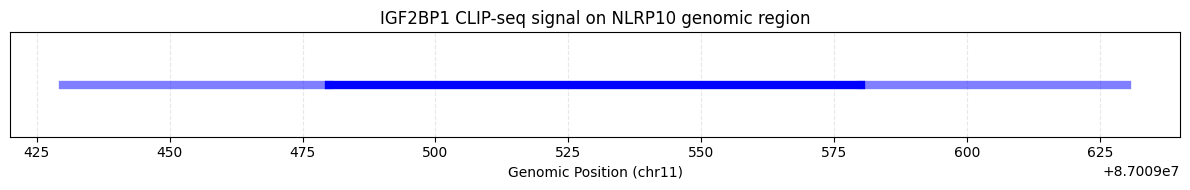

In [59]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. NLRP10 유전체 위치
NLRP10_chr = "chr11"
NLRP10_start = 87009430
NLRP10_end = 87012471

# 2. bedgraph 로드
bedgraph_path = "GSM6142364_IP_1.bedgraph"
bed_df = pd.read_csv(bedgraph_path, sep="\t", header=None, names=["chrom", "start", "end", "signal"])

# 3. NLRP10 내 시그널 있는 위치 필터링
nlrp10_clip = bed_df[
    (bed_df["chrom"] == NLRP10_chr) &
    (bed_df["end"] > NLRP10_start) &
    (bed_df["start"] < NLRP10_end) &
    (bed_df["signal"] > 0)
].copy()

# 4. 출력: 바인딩된 위치
print("✅ IGF2BP1 CLIP-seq signal in NLRP10:")
print(nlrp10_clip)

# 5. 시각화
plt.figure(figsize=(12, 2))
for _, row in nlrp10_clip.iterrows():
    plt.plot([row["start"], row["end"]], [0, 0], lw=6, color="blue", alpha=row["signal"]/max(nlrp10_clip["signal"]))

plt.title("IGF2BP1 CLIP-seq signal on NLRP10 genomic region")
plt.xlabel("Genomic Position (chr11)")
plt.yticks([])
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


✅ IGF2BP1 CLIP-seq signal in NLRP10:
        chrom     start       end  signal
931101  chr11  87009775  87009915     2.0


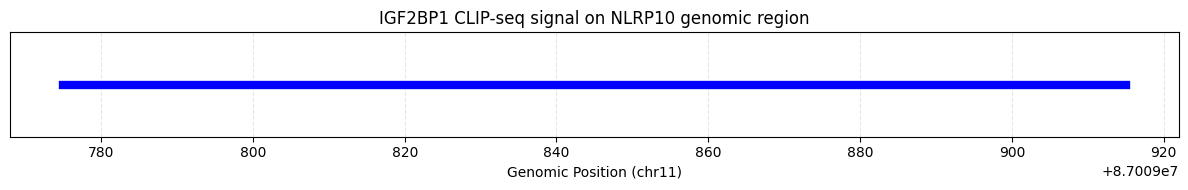

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. NLRP10 유전체 위치
NLRP10_chr = "chr11"
NLRP10_start = 87009430
NLRP10_end = 87012471

# 2. bedgraph 로드
bedgraph_path = "GSM6142366_IP_2.bedgraph"
bed_df = pd.read_csv(bedgraph_path, sep="\t", header=None, names=["chrom", "start", "end", "signal"])

# 3. NLRP10 내 시그널 있는 위치 필터링
nlrp10_clip = bed_df[
    (bed_df["chrom"] == NLRP10_chr) &
    (bed_df["end"] > NLRP10_start) &
    (bed_df["start"] < NLRP10_end) &
    (bed_df["signal"] > 0)
].copy()

# 4. 출력: 바인딩된 위치
print("✅ IGF2BP1 CLIP-seq signal in NLRP10:")
print(nlrp10_clip)

# 5. 시각화
plt.figure(figsize=(12, 2))
for _, row in nlrp10_clip.iterrows():
    plt.plot([row["start"], row["end"]], [0, 0], lw=6, color="blue", alpha=row["signal"]/max(nlrp10_clip["signal"]))

plt.title("IGF2BP1 CLIP-seq signal on NLRP10 genomic region")
plt.xlabel("Genomic Position (chr11)")
plt.yticks([])
plt.grid(axis="x", linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


In [62]:
import os

# 모든 PWM 파일 경로
pwm_dir = "/content/drive/MyDrive/cd5l/RBPDB_motifs/PWMDir/PWMDir"
min_score = 4.0
all_hits = {}  # {RBP_label: [motif_hit_dict, ...]}

# 서열 준비 (이미 있음): nlrp10_3utr_seq

# 함수 재사용: load_pwm, pwm_score, scan_pwm_on_seq_with_details

# 전체 RBP 순회
for pwm_file in sorted(os.listdir(pwm_dir)):
    if not pwm_file.endswith(".pwm"):
        continue

    pwm_path = os.path.join(pwm_dir, pwm_file)
    pwm = load_pwm(pwm_path)
    hits = scan_pwm_on_seq_with_details(pwm, nlrp10_3utr_seq, min_score=min_score)

    if hits:  # hit된 motif만 기록
        rbp_name = pwm_file.replace(".pwm", "")
        all_hits[rbp_name] = [
            {"start": start, "length": len(seq), "seq": seq, "score": score}
            for (start, end, seq, score) in hits
        ]

# ✅ 결과 출력
print(f"✅ Motif matched RBPs: {len(all_hits)} proteins")
for rbp, motifs in all_hits.items():
    print(f"🧬 {rbp}: {len(motifs)} hits, first seq: {motifs[0]['seq']} (score: {motifs[0]['score']})")


✅ Motif matched RBPs: 72 proteins
🧬 1004_8676391: 1 hits, first seq: cccaaatttggaagcaac (score: 4.17)
🧬 1026_10858445: 12 hits, first seq: aatcaaagaag (score: 6.08)
🧬 1052_17318228: 11 hits, first seq: ctcaa (score: 8.63)
🧬 1053_17318228: 28 hits, first seq: ctcta (score: 4.58)
🧬 114_7499328: 31 hits, first seq: aagatc (score: 7.95)
🧬 115_7499328: 31 hits, first seq: aagatc (score: 7.08)
🧬 1169_19561594: 26 hits, first seq: aaagaaa (score: 4.53)
🧬 1170_19561594: 10 hits, first seq: gttt (score: 4.4)
🧬 1171_19561594: 18 hits, first seq: agatctctatgagga (score: 4.02)
🧬 1173_19561594: 28 hits, first seq: agga (score: 4.62)
🧬 1174_19561594: 45 hits, first seq: cctaat (score: 4.42)
🧬 1175_19561594: 12 hits, first seq: aatgcaa (score: 4.05)
🧬 1176_19561594: 5 hits, first seq: gctggtg (score: 5.4)
🧬 1177_19561594: 4 hits, first seq: gctgct (score: 4.18)
🧬 1186_17893325: 3 hits, first seq: gtcc (score: 6.34)
🧬 1213_8021254: 26 hits, first seq: caatgc (score: 5.24)
🧬 1215_16041388: 13 hits, fir